In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

import xarray as xr

import cartopy.crs as ccrs

from IPython.display import HTML

sagnn1 = xr.open_dataset('final_output.nc')
# sagnn1 = xr.open_dataset('80x80_best.nc')
sagnn1

<xarray.Dataset> Size: 1MB
Dimensions:               (time: 2, prediction_timedelta: 12, longitude: 80,
                           latitude: 80)
Coordinates:
  * time                  (time) datetime64[ns] 16B 2020-11-03T06:00:00 2020-...
  * prediction_timedelta  (prediction_timedelta) int64 96B 0 1 2 3 ... 8 9 10 11
  * latitude              (latitude) float64 640B -38.75 -38.5 ... -19.25 -19.0
  * longitude             (longitude) float64 640B 15.0 15.25 ... 34.5 34.75
Data variables:
    wind_speed            (time, prediction_timedelta, longitude, latitude) float32 614kB ...
    target                (time, prediction_timedelta, longitude, latitude) float32 614kB ...

In [4]:

pred = sagnn1['wind_speed']
actual = sagnn1['target']

def plot_example(prediction, actual, seed: int = 0, offset: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
    lon, lat = actual.longitude, actual.latitude
        
    bounds = [lon.min().item(), lon.max().item(), lat.min().item(), lat.max().item()]

    vmin = min(prediction.values.min(), actual.values.min())
    vmax = max(prediction.values.max(), actual.values.max())

    pred = prediction.isel(time=seed)
    target = actual.isel(time=seed + offset)

    init_time_pred = pred.time.values
    init_time_target = target.time.values
    
    times_pred = np.array(prediction['prediction_timedelta'].values).astype('timedelta64[3h]')
    times_pred = np.array([np.datetime64(init_time_pred + time) for time in times_pred])

    times_target = np.array(actual['prediction_timedelta'].values).astype('timedelta64[3h]')    
    times_target = np.array([np.datetime64(init_time_target + time) for time in times_target])

    times = times_target

    print('Predictions:', times_pred[0])
    print('Actual:', times_target[0])


    fig, axs = plt.subplots(1, 3, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

    # print('Predictions:', pred['wind_speed'].shape)

    for ax in axs:
        ax.coastlines()
        ax.set_extent(bounds, crs=ccrs.PlateCarree())
        
    pred_states = pred.transpose('prediction_timedelta', 'latitude', 'longitude').values
    target_states = target.transpose('prediction_timedelta', 'latitude', 'longitude').values
    err_states = np.abs(target_states - pred_states)
    emin = err_states.min() 
    emax = err_states.max()

    pr = axs[0].contourf(lon, lat, pred_states[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
    ac = axs[1].contourf(lon, lat, target_states[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
    err = axs[2].contourf(lon, lat, err_states[0], levels=levels, vmin=emin, vmax=emax, transform=ccrs.PlateCarree(), cmap='coolwarm')
    axs[0].set_title(f'Predicted {0} - {times[0]}')
    axs[1].set_title(f'Actual {0} - {times[0]}')
    axs[2].set_title(f'Error {0} - {times[0]}')

    fig.colorbar(pr, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)', shrink=0.3)
    fig.colorbar(ac, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)', shrink=0.3)
    fig.colorbar(err, ax=axs[2], orientation='vertical', label='Absolute Error (m/s)', shrink=0.3)

    print('Maximum error: ', emax)

    def animate(i):
        for ax in axs:
            ax.clear()
            ax.coastlines()

        axs[0].contourf(lon, lat, pred_states[i], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].contourf(lon, lat, target_states[i], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[2].contourf(lon, lat, err_states[i], levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')

        rect = [16, 33, -23, -35]
        rect_lon = [rect[0], rect[1], rect[1], rect[0], rect[0]]
        rect_lat = [rect[2], rect[2], rect[3], rect[3], rect[2]]
        axs[0].plot(rect_lon, rect_lat, transform=ccrs.PlateCarree(), color='red')
        axs[1].plot(rect_lon, rect_lat, transform=ccrs.PlateCarree(), color='red')
        axs[2].plot(rect_lon, rect_lat, transform=ccrs.PlateCarree(), color='red')

        axs[0].set_title(f'Predicted {i} - {times[i]}') # .strftime("%Y-%m-%d %H:%M:%S")
        axs[1].set_title(f'Actual {i} - {times[i]}')
        axs[2].set_title(f'Error {i} - {times[i]}')

            
    frames = pred_states.shape[0]

    interval = 1000 / frame_rate

    ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

    plt.close(fig)

    return HTML(ani.to_jshtml())


plot_example(pred, actual, seed=1, offset=0, frame_rate=2, levels=20)

Predictions: 2020-11-03T09:00:00.000000000
Actual: 2020-11-03T09:00:00.000000000
Maximum error:  17.740896


Predictions: 2020-11-03T06:00:00.000000000
Actual: 2020-11-03T06:00:00.000000000


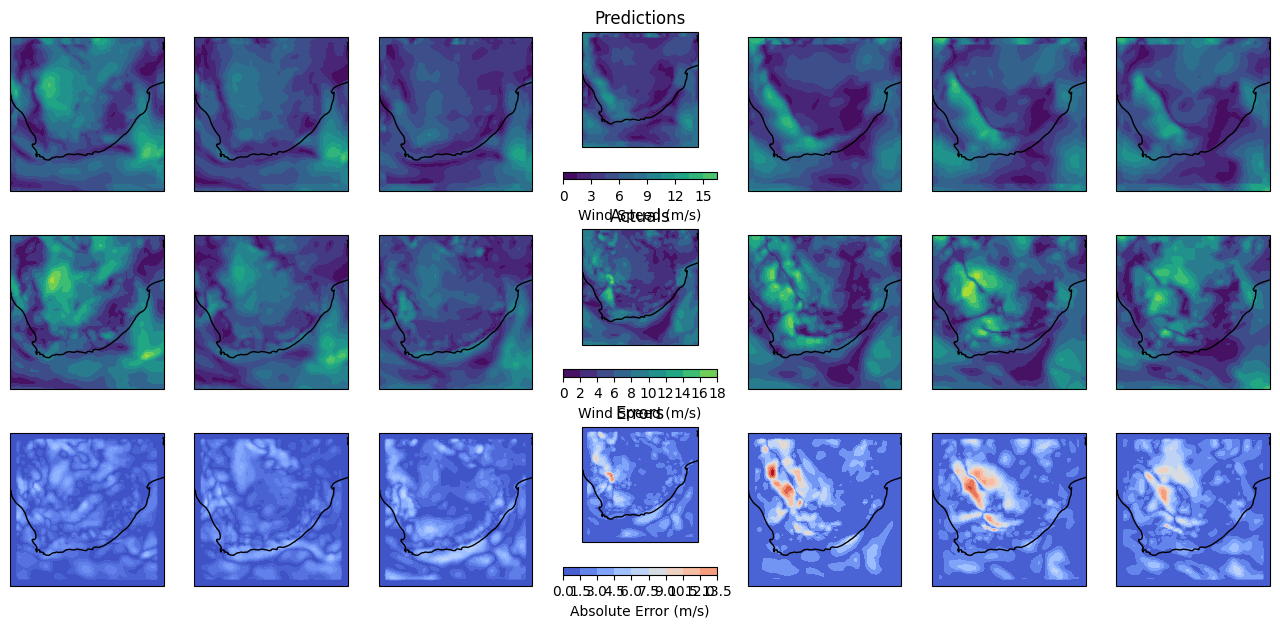

In [3]:
def plot_all(prediction, actual, seed: int = 0, offset: int = 0, levels: int = 10) -> None:
    lon, lat = actual.longitude, actual.latitude
        
    bounds = [lon.min().item(), lon.max().item(), lat.min().item(), lat.max().item()]

    vmin = min(prediction.values.min(), actual.values.min())
    vmax = max(prediction.values.max(), actual.values.max())

    pred = prediction.isel(time=seed)
    target = actual.isel(time=seed + offset)

    init_time_pred = pred.time.values
    init_time_target = target.time.values
    
    times_pred = np.array(prediction['prediction_timedelta'].values).astype('timedelta64[3h]')
    times_pred = np.array([np.datetime64(init_time_pred + time) for time in times_pred])

    times_target = np.array(actual['prediction_timedelta'].values).astype('timedelta64[3h]')    
    times_target = np.array([np.datetime64(init_time_target + time) for time in times_target])

    times = times_target

    print('Predictions:', times_pred[0])
    print('Actual:', times_target[0])

    fig, axs = plt.subplots(3, 7, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

    for ax in axs.flatten():
        ax.coastlines()
        ax.set_extent(bounds, crs=ccrs.PlateCarree())

    pred_states = pred.transpose('prediction_timedelta', 'latitude', 'longitude').values
    target_states = target.transpose('prediction_timedelta', 'latitude', 'longitude').values
    err_states = np.abs(target_states - pred_states)
    emin = err_states.min() 
    emax = err_states.max()

    for i in range(7):
        pr = axs[0, i].contourf(lon, lat, pred_states[i], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        ac = axs[1, i].contourf(lon, lat, target_states[i], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        err = axs[2, i].contourf(lon, lat, err_states[i], levels=levels, vmin=emin, vmax=emax, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    axs[0, 3].set_title(f'Predictions')
    axs[1, 3].set_title(f'Actuals')
    axs[2, 3].set_title(f'Errors')

    fig.colorbar(pr, ax=axs[0, 3], orientation='horizontal', label='Wind Speed (m/s)')
    fig.colorbar(ac, ax=axs[1, 3], orientation='horizontal', label='Wind Speed (m/s)')
    fig.colorbar(err, ax=axs[2, 3], orientation='horizontal', label='Absolute Error (m/s)')



plot_all(pred, actual, seed=0, offset=0, levels=10)